Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

/Users/paulchainieux/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


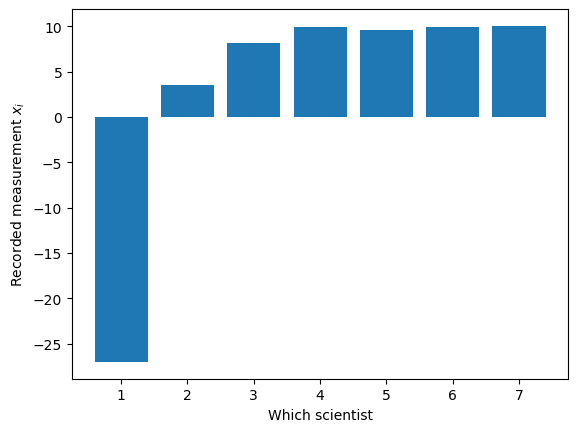

In [2]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


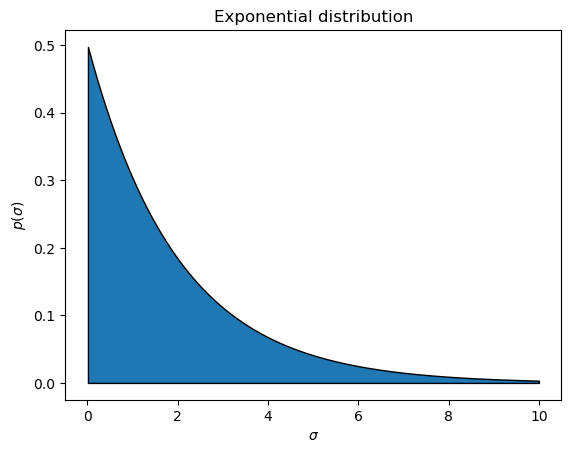

In [3]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
plt.title("Exponential distribution");

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [4]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar (torch tensor of zero dimensions)
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, measurements | alpha, beta), scalar (torch tensor)
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!
    """
    assert mu.dim() == 0  
    assert sigma.shape == (7,)
    
    # We return -infinity if the sigma is negative or 0 
    if torch.any(sigma <= 0):
        return -float('inf')

    # To avoid any type errors in the calculation that follow, we convert alpha and beta to tensors if they are not already
    if not torch.is_tensor(alpha):
        alpha = torch.tensor(alpha, dtype=mu.dtype)
    if not torch.is_tensor(beta):
        beta = torch.tensor(beta, dtype=mu.dtype)

    # We have to define the measurements inside the function since they aren't in the input parameters
    measurements = torch.tensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056], dtype=mu.dtype)

    # The log-joint probability is calculated as follows: p(x_i, sigma_i, mu | alpha, beta) = p(mu | alpha) * p(sigma_i | beta) * p(x_i | mu, sigma)
    # We compute below each of these quantities in turn
    # We compute the gaussian log-prior probability of mu: log p(mu)
    log_p_mu = -0.5 * torch.log(torch.tensor(2.0) * torch.tensor(torch.pi) * alpha**2) - (mu**2) / (2 * alpha**2)

    # We compute the exponenyial log-prior probability of sigma: log p(sigma)
    log_p_sigma = torch.sum(torch.log(beta) - beta * sigma)
    
    # We then compute the log-ikelihood of the measurements given mu and sigma: log p(measurements | mu, sigma)
    log_p_measurements_given_mu_sigma = torch.sum(-0.5 * torch.log(2 * torch.tensor(torch.pi) * sigma**2) - ((measurements - mu)**2) / (2 * sigma**2))
    
    # We calculate the log-joint probability, which is the sum of the three: 
    log_joint = log_p_mu + log_p_sigma + log_p_measurements_given_mu_sigma
    return log_joint


#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [5]:
# (GRADING)

In [6]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [7]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    
    # We choose to place a normal distribution around current values of mu and sigma
    # We choose proposal standard deviations for mu and sigma, these have been adjusted manually to have an acceptance rate close to 25%
    # The standard deviations were chosen somewhat aribtrarily using the first graph displayed in Part 1
    mu_proposal_std = 0.24 
    sigma_proposal_std = torch.tensor([1.0, 0.6, 0.4, 0.3, 0.2, 0.2, 0.2])
    
    # We then define the normal distributions centered on mu and sigma_i respectively
    q_mu = dist.Normal(mu, mu_proposal_std)
    q_sigma = dist.Normal(sigma, sigma_proposal_std)
    
    return q_mu, q_sigma


### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [8]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [9]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """

    # We call our get_mcmc_proposal function to get the normal distributions on mu and sigma
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)

    # We then sample from the distributions to propose new values for mu and sigma
    mu_proposed = q_mu.sample()
    sigma_proposed = q_sigma.sample()

    # We compute log joint probabilities for the proposed new values of mu and sigma
    log_p_current = log_joint(mu, sigma, alpha, beta)
    log_p_proposed = log_joint(mu_proposed, sigma_proposed, alpha, beta)

    # We compute acceptance probability (the minimum of 1 and accept_ratio, which ensures it's between 0 and 1)
    accept_ratio = torch.exp(log_p_proposed - log_p_current)
    accept_prob = min(1, accept_ratio.item())

    # A random number n is drawn from a uniform distribution on [0, 1], which once compared to the acceptance probability, determines if we accept or reject the proposal
    n = torch.rand(1).item()
    if n < accept_prob:
        # Accept the proposal
        mu_next = mu_proposed
        sigma_next = sigma_proposed
        accepted = True
    else:
        # Reject the proposal
        mu_next = mu
        sigma_next = sigma
        accepted = False

    return mu_next, sigma_next, accepted


## Running MCMC

We've supplied the outer loop for you -- it will call and execute your `mcmc_step` function. You should *not* need to edit it!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [10]:
def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [11]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """
    
    N_samples = 5000
    N_burnin = 1000
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [12]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted)

acceptance rate: 0.3176


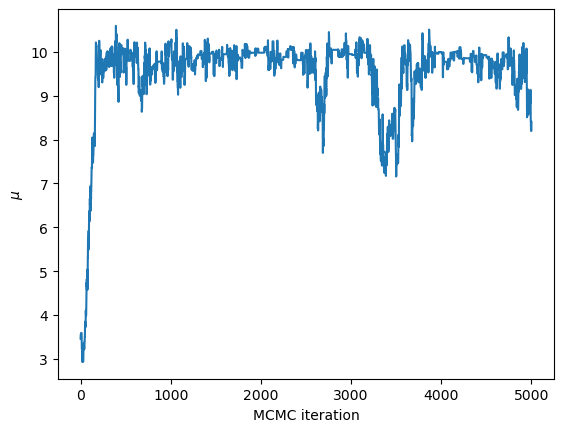

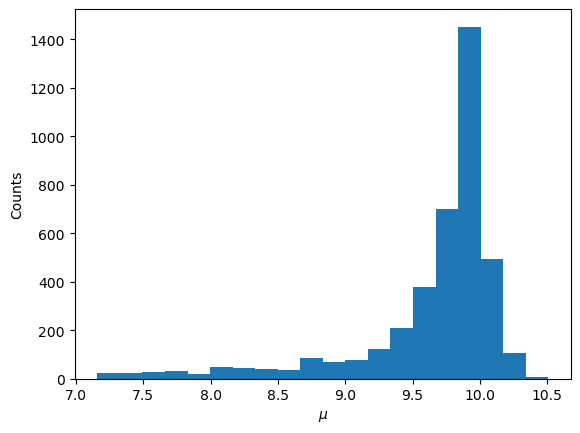

In [13]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\mu$")
plt.ylabel("Counts");

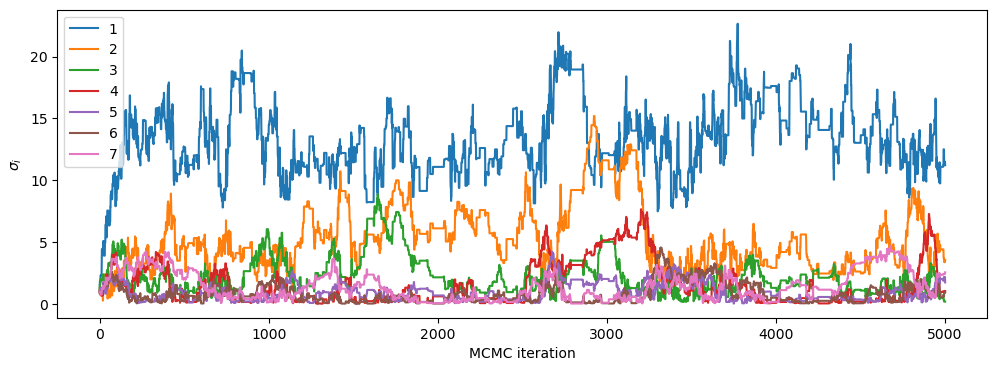

In [14]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\sigma_i$");

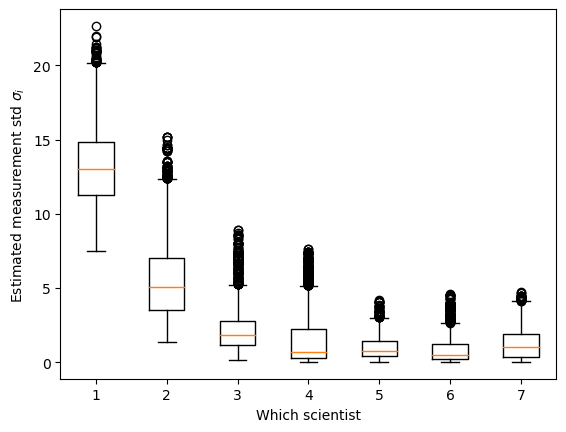

In [15]:
plt.boxplot(sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [16]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """

    # We trucate the mu_chain by discarding the first N_burnin samples (keeping only the samples after burn-in)
    mu_samples = mu_chain[N_burnin:]
    
    # We then calculate the the mean of the remaining mu samples
    mu_estimate = mu_samples.mean().item()  
    
    return mu_estimate
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    
    # We trucate the mu_chain by discarding the first N_burnin samples (keeping only the samples after burn-in)
    mu_samples = mu_chain[N_burnin:]
    
    # We compute the fraction of samples where mu < 9:
    # (mu_samples < 9) creates a boolean tensor, where each element is True if the corresponding sample in mu_samples is less than 9 and False otherwise
    # .float() converts this boolean tensor to a float tensor, where True becomes 1.0 and False becomes 0.0
    # .mean() calculates the mean of these values, giving the fraction of samples where mu < 9
    # .item() converts the result from a tensor to a scalar, returning it as a regular float, this is what we will return!
    indicator = (mu_samples < 9).float()
    estimate = indicator.mean().item()  
    
    return estimate
    

In [17]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.6497
Pr(mu < 9) = 0.1125


# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, for up to two points each:

1. Describe your choices of MCMC proposal distributions. How did you select them? How do you know they are "good"?
2. In your `mcmc_step`, we consider 8 random variables, $\mu, \sigma_1, \dots, \sigma_7$, but you probably implemented this using a single accept-reject step (i.e., you propose new values for all random variables, and then jointly accept all of them, or not). Suppose someone suggested instead proposing for each of these variables one-at-a-time sequentially, including a separate accept-reject step after each. Might this be a good idea, and why or why not?

### Question 1:

I had a few possible choices for the MCMC proposal distribution. The problem is centred around finding the correct value for $\mu$, so we know that a sensible distribution to choose should be unimodal. Also, I wanted to implement a Metropolis-Hastings algorithm, for which the rejection kernel A is given by:
\
\
$A(x_{i+1} \mid x_i) := \min \left\{ 1, \frac{q(x_i \mid x_{i+1}) p(x_{i+1})}{q(x_{i+1} \mid x_i) p(x_i)} \right\}$
\
\
If the proposal distribution is symmetric ($q(x_i \mid x_{i+1}) = q(x_{i+1} \mid x_i)$), the rejection kernel simplifies to:
\
\
$A(x_{i+1} \mid x_i) := \min \left\{ 1, \frac{p(x_{i+1})}{p(x_i)} \right\}$
\
\
With this in mind, I considered a Gaussian distribution and  Student's t-distribution. The key difference is that the Student's t-distribution is heavy tailed, meaning we would take on overage larger steps than with the Gaussian distribution, which could mean the chain would converge quicker. This heavy tail is also very useful to escape local modes, but the posterior being unimodal this property isn't very useful to us. After running the algorithm with a Gaussian proposal distribution for both $\mu$ and $\sigma$, I saw from the trace plot that the chain converged quickly (the burn-in phase was short) so I didn't feel the need to implement Student's t-distribution. Additionally, a good measure of a quality proposal distribution is the acceptance rate, which on our case fell around 25\%-30\%. This is considered to be optimal and makes the algorithm efficient. In conclusion, I know that the Gaussian choice for the proposal distribution is good because the MCMC sampler efficiently explores the target distribution, converges quickly to the stationary distribution and has an optimal acceptance rate. This can all be seen from the plots. 


### Question 2: 

Proposing updates for each variable one at a time with separate accept-reject steps can have both advantages and disadvantages. 
\
\
The potential advantage of component-wise proposals is when dealing with high dimensions in the feature space. If we have many features, proposing changes to all of them at once can lead to low acceptance rates. This is because the chance that all proposed values will collectively lead to a higher probability would be smaller. So updating one variable at a time would likely help achieve higher (more optimal) acceptance rates for each individual variable, making it easier to explore the feature space. Also, in our case, we require $\sigma$ to be positive, and the way we coded it means we discard the whole tensor if one of the components is negative. If we have 100 scientists instead of 7, the odds of having a negative $\sigma$ would be very high, which would make a lot of resampling happen and the algorithm a lot less efficient. The component by component proposals would help to deal with this issue.
\
\
On the other hand, the disadvantages of the technique include sampling efficiency. We would require an accept-reject decision for each variable, increasing computational cost and time significantly, both for high and low dimensional feature spaces. In essence, to get $N_{\text{samples}}$ accepted proposals for each variable, you need $N_{\text{variables}} \times N_{\text{samples}}$ total iterations, which is a lot more iterations than the batch accept-reject technique for the same level of exploration fo the feature space. In our case were we only have 8 features, I don't think that it would be a good idea to implement this new methdod, as it would increase computational cost without very significant improvement to the exploration of the feature space. 

#### Ignore the following cells. They are used by the grading system.

In [18]:
# (GRADING)

In [19]:
# (GRADING)

In [20]:
# (GRADING)

In [21]:
# (GRADING)

In [22]:
# (GRADING)

# EXTRA CREDIT TASK #4 (2 points): Estimate $\alpha$ and $\beta$

Did we choose the hyperparameters $\alpha$ and $\beta$ well? Or were these poor selections?

One way of checking whether $\alpha$ and $\beta$ are set well is by computing a marginal likelihood estimate, i.e. estimating $p(x | \alpha, \beta)$ for different choices of $\alpha, \beta$.

However, a different option is to *also* perform Bayesian inference over $\alpha$ and $\beta$! To do this, we need to do three things:

1. Define a prior $p(\alpha, \beta)$
2. Define MCMC proposals $q(\alpha' | \alpha)$ and $q(\beta' | \beta)$
3. Update the MCMC algorithm itself to also sample $\alpha, \beta$.

To do this, this involves targeting the joint probability distribution

$$p(x,\mu,\sigma,\alpha,\beta) = p(x | \mu, \sigma)p(\mu | \alpha)p(\sigma | \beta)p(\alpha)p(\beta).$$

You can write your MCMC algorithm so that it alternates between doing updates on $\mu, \sigma$ (using your existing `mcmc_step` function) and doing updates on $\alpha, \beta$ (using a new `mcmc_step_hyperparams` function).

To do this you need to implement two things:

1. `log_prior_alpha_beta`: given $\alpha,\beta$, return $\log p(\alpha, \beta)$. You are free to define whatever sort of prior you think is appropriate.
2. `mcmc_step_hyperparams`: do a single MCMC step (including accept / reject) to update $\alpha, \beta$.

These will then be called by the `run_mcmc_bonus` function, below.

In [23]:
def log_prior_alpha_beta(alpha, beta):
    """
    Define a prior distribution on alpha and beta, and return its log probability.

    INPUT:
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    log_prob : scalar, `log p(alpha, beta)`
    """
    # I have chosen to use a Uniform distribution as a prior for alpha and beta, because it 
    #   assigns equal probability to all values within the specified range, which shows we don't 
    #   have any strong prior belief about the specific values of alpha and beta. Hopefully this will let 
    #   us find the optimal values within the range I chose. 
    # In PyTorch, the Uniform distribution is defined using [low, high] values, so we first need to make sure that
    #   alpha and beta fall within this region
    # The region were chosen with regards to the values of alpha and beta used earlier in the problem
    if alpha <= 0 or alpha >= 100 or beta <= 0 or beta >= 20:
        return -float('inf')

    # We now define Uniform distribution priors for alpha and beta
    uniform_alpha = dist.Uniform(low=0.0, high=100.0)
    uniform_beta = dist.Uniform(low=0.0, high=50.0)

    # We compute the log probabilities
    log_p_alpha = uniform_alpha.log_prob(alpha)
    log_p_beta = uniform_beta.log_prob(beta)

    # The total log-prior is the sum of the log-priors of alpha and beta
    log_prob = log_p_alpha + log_p_beta

    return log_prob



In [24]:
def mcmc_step_hyperparams(mu, sigma, alpha, beta):
    """
    Run an MCMC step on alpha and beta.

    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    alpha_next : the next value of alpha in the MCMC chain
    beta_next  : the next value of beta in the MCMC chain
    accepted   : a boolean value indicating whether the proposal was accepted
    """
    # We first propose standard deviations which we will use in the Normal distributions we fit onto alpha and beta 
    proposal_std_alpha = 5.0
    proposal_std_beta = 0.1

    # We then generate proposal distributions with the current alpha and beta
    proposal_dist_alpha = dist.Normal(loc=alpha, scale=proposal_std_alpha)
    proposal_dist_beta = dist.Normal(loc=beta, scale=proposal_std_beta)

    # We propose new alpha and beta from their distribution
    alpha_proposed = proposal_dist_alpha.sample()
    beta_proposed = proposal_dist_beta.sample()

    # We compute the log posterior probabilities for current and proposed alpha and beta
    log_posterior_current = log_prior_alpha_beta(alpha, beta) + log_joint(mu, sigma, alpha, beta)
    log_posterior_proposed = log_prior_alpha_beta(alpha_proposed, beta_proposed) + log_joint(mu, sigma, alpha_proposed, beta_proposed)

    # We compute log acceptance ratio
    log_accept_ratio = log_posterior_proposed - log_posterior_current

    # This is as before, we generate n which will ne compared to the log_accept_ratio to determine 
    #   whether we accpet or reject the sample
    n = torch.rand(1).item()
    # We make n into a tensor to avoid any type errors when taking the log afterwards
    n = torch.tensor(n)
    log_n = torch.log(n)
    if log_n < log_accept_ratio:
        # Accept the proposal
        alpha_next = alpha_proposed
        beta_next = beta_proposed
        accepted = True
    else:
        # Reject the proposal
        alpha_next = alpha
        beta_next = beta
        accepted = False

    return alpha_next, beta_next, accepted

### Run this MCMC algorithm, and plot the results.

What do you think?

1. Are these results qualitatively different?
2. Were the original choices of $\alpha, \beta$ reasonable?
3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?

## Question 1: 

From the graphs displayed below, we see that the results are qualitatively the same: The peak for $\mu$ is around 10, which is close to the value we found previously in the problem. 



## Question 2: 

The values for $\alpha$ and $\beta$ we use previously were reasonable but a little higher than what we found here. Looking at the graphs, we see that the mode for $\alpha$ is around 10 and the one for $\beta$ is around 0.13. Their previous values being 50 and 0.5, we see that we have kept the same order of magnitude. 


## Question 3: 

As follows from questions 1 and 2, the results don't seem to be very sensitive to the values of $\alpha$ and $\beta$, since we get a similar value for $\mu$ regardless. 



In [25]:
def run_mcmc_bonus(N_iters, mu_init, sigma_init, alpha_init, beta_init):
    """ Run an MCMC algorithm for a fixed number of iterations.
    
    This also runs MCMC on "hyperparameters" alpha and beta.
    
    """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    alpha_chain = [alpha_init]
    beta_chain = [beta_init]
    for _ in range(N_iters):
        alpha, beta, accepted = mcmc_step_hyperparams(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        alpha_chain.append(alpha)
        beta_chain.append(beta)

        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), torch.stack(alpha_chain), torch.stack(beta_chain)

In [26]:
new_mu_chain, new_sigma_chain, alpha_chain, beta_chain = run_mcmc_bonus(N_samples, mu_chain[-1], sigma_chain[-1], torch.tensor(50.0), torch.tensor(0.5))

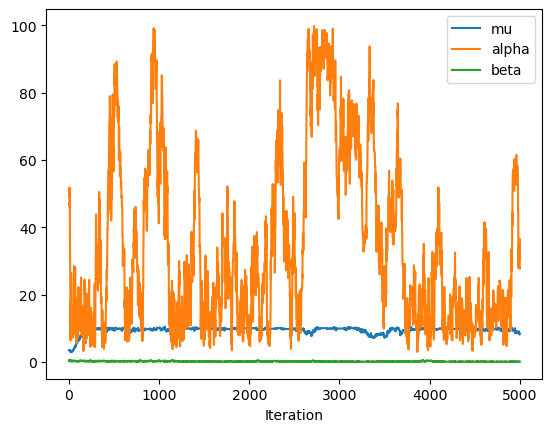

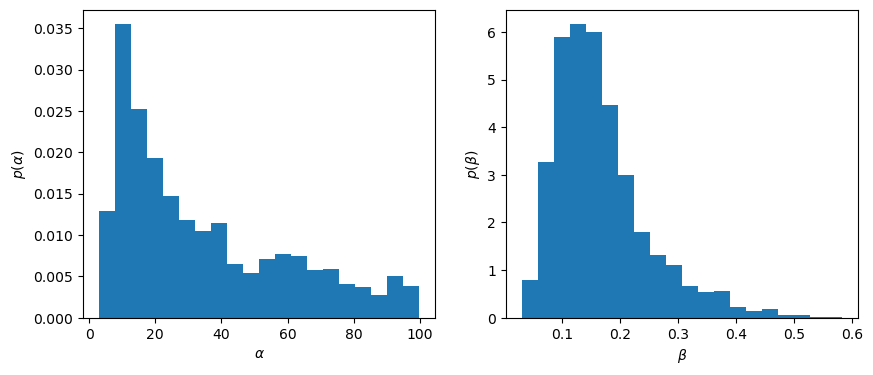

In [27]:
plt.plot(mu_chain)
plt.plot(alpha_chain);
plt.plot(beta_chain);
plt.legend(['mu', 'alpha', 'beta']);
plt.xlabel("Iteration");
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(alpha_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\alpha$")
plt.ylabel("$p(\\alpha)$")
plt.subplot(122)
plt.hist(beta_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\beta$")
plt.ylabel("$p(\\beta)$");

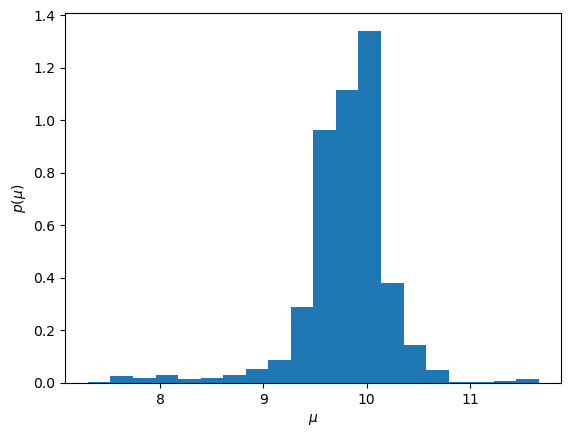

In [28]:
plt.hist(new_mu_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$");

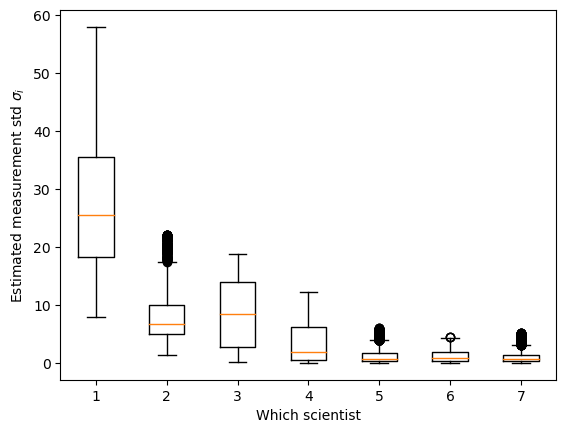

In [29]:
plt.boxplot(new_sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

In [30]:
# (GRADING)

In [31]:
# (GRADING)